กดตรง copy to my drive ก่อนนะ ( อยู่ข้างบนมั้ง ) ไม่งั้นโค้ดทางนี้จะเปลี่ยนด้วย

# Import  lib

In [ ]:
import tensorflow as tf
import numpy as np
from google.colab import drive
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from textwrap import wrap
from google.colab import drive
from tensorflow.keras.utils import plot_model

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

# Connect google drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# PREPARE DATA ( change to your path )

place your captions path

In [ ]:
# file_path = "/content/drive/MyDrive/MachineLearning/project/data_for_ml_924.csv"
file_path = "/content/drive/MyDrive/MachineLearning/project/food.csv"

convert to csv format

In [ ]:
df = pd.read_csv(file_path)

check unique image

In [ ]:
np.unique(df["image"])

array(['190246_0.jpg', '190248_0.jpg', '190249.jpg', '192437_0.jpg',
       '192441_0.jpg', '192442_0.jpg', '192444_0.jpg', '199844_0.jpg',
       '199846_0.jpg', '199848_0.jpg', '199852_0.jpg', '200085_0.jpg',
       '200086_0.jpg', '200088_0.jpg', '200089_0.jpg', '200090_0.jpg',
       '200091_0.jpg', '200092_0.jpg', '200093_0.jpg', '200094_0.jpg',
       '200123_0.jpg', '200124_0.jpg', '200126_0.jpg', 'IMG_0225.JPG',
       'IMG_0226.JPG', 'IMG_0229.JPG', 'IMG_0230.JPG', 'IMG_0231.JPG',
       'IMG_0232.JPG', 'IMG_0233.JPG', 'IMG_0235.JPG', 'IMG_0257.JPG',
       'IMG_0258.JPG', 'IMG_0259.JPG', 'IMG_0386.JPG', 'IMG_0389.JPG',
       'IMG_0390.JPG', 'IMG_0391.JPG', 'IMG_20231007_141008.jpg',
       'IMG_25660913_083131.jpg', 'IMG_25660913_132501.jpg',
       'IMG_25660920_150148.jpg', 'S__12435466_0.jpg',
       'S__12435469_0.jpg', 'S__12435483_0.jpg', 'S__12435484_0.jpg',
       'S__12435487_0.jpg', 'S__12435491_0.jpg', 'S__23502851_0.jpg',
       'S__23502853_0.jpg', 'S__23502854_

Create variable
- store image column to images variable
- store captions column to captions variable

In [ ]:
images = df['image']
captions = df['caption']

Check the first 30 captions

In [ ]:
captions[30:]

30            A man is working on the laptop
31              A man is sitting in the room
32     A man is sitting infrontof the laptop
33            A man is working on his laptop
34          A student is sitting in the room
                       ...                  
330         ? woman is standing on the floor
331                A woman is standing ? ? ?
332        A woman is standing on the ground
333                A woman is standing ? ? ?
334        ? woman is standing on the ground
Name: caption, Length: 305, dtype: object

Replace ? with spacebar for every captions and store it into all_captions variable

In [ ]:
all_captions = []

for caption in captions:
  caption_splited = ["" if word == "?" else word for word in caption.split()]
  all_captions.append(caption_splited)

check the value of all_captions

In [ ]:
all_captions

[['Two', 'students', 'are', 'working', 'on', 'the', 'laptop'],
 ['', 'Students', 'are', 'sitting', 'infrontof', '', 'laptop'],
 ['Two', 'students', 'are', 'sitting', 'on', 'the', 'chair'],
 ['', 'students', 'are', 'working', 'in', 'the', 'room'],
 ['', 'Student', 'is', 'sitting', 'on', 'the', 'chair'],
 ['A', 'man', '', 'wearing', '', 'a', 'shirt'],
 ['A', 'man', 'is', 'sitting', 'on', 'the', 'table'],
 ['A', 'man', 'is', 'sitting', 'in', 'the', 'room'],
 ['A', 'man', 'is', 'sitting', 'in', '', 'Room'],
 ['A', 'man', 'is', 'sitting', 'infrontof', 'a', 'laptop'],
 ['The', 'man', 'is', 'sitting', 'on', 'the', 'chair'],
 ['A', 'man', '', 'wearing', '', 'a', 'glasses'],
 ['', 'man', 'is', 'sitting', 'on', 'the', 'chair'],
 ['A', 'man', '', 'Wearing', '', 'a', 'shirt'],
 ['A', 'man', '', 'wearing', '', 'a', 'coat'],
 ['A', 'man', 'is', 'standing', 'on', 'the', 'ground'],
 ['A', 'man', '', 'wearing', '', 'the', 'coat'],
 ['', 'Man', '', 'wearing', '', 'the', 'coat'],
 ['A', 'man', 'is', 'sta

TO LOWER CASE AND STORE INTO THE LIST
- convert caption to lower case [ from A to a, from B to b, etc]
- store it into list [ We have 7 list for store every part of sentences ]

In [ ]:
first_article = []
subject = []
verb_to_be = []
verb = []
preposition = []
second_article = []
objective = []

for caption in all_captions:
  first_article.append(caption[0].lower())
  subject.append(caption[1].lower())
  verb_to_be.append(caption[2].lower())
  verb.append(caption[3].lower())
  preposition.append(caption[4].lower())
  second_article.append(caption[5].lower())
  print(caption[6].lower())
  objective.append(caption[6].lower())

# first_article = np.unique(first_article)
# subject = np.unique(subject)
# verb_to_be = np.unique(verb_to_be)
# verb = np.unique(verb)
# preposition = np.unique(preposition)
# second_article = np.unique(second_article)
# objective = np.unique(objective)

# first_article = first_article
# subject = subject
# verb_to_be = verb_to_be
# verb = verb
# preposition = preposition
# second_article = second_article
# objective = objective

laptop
laptop
chair
room
chair
shirt
table
room
room
laptop
chair
glasses
chair
shirt
coat
ground
coat
coat
ground
coat
table
table


room
room
room
table
room
room
laptop
room
laptop
laptop
room
thing
shirt



ground
food
shirt
thing
coat
chair
shirt
thing
glasses
coat
shirt
glasses
food
chair
thing

shirt
food

glasses
shirt
shirt
floor
ground
ground
shirt
shirt
ground
ground
ground
shirt
shirt
ground
ground
ground
shirt
shirt
floor
ground
ground
uniform
uniform

floor
uniform
uniform
ground
ground
uniform
uniform
ground

ground
ground
uniform
uniform
uniform

ground
ground
thing
food
thing
thing
thing
ground
thing
uniform
ground
ground
shirt
thing

shirt

food
shirt
food
chair
chair
food
shirt
food
chair
chair
chair
laptop
laptop
laptop
laptop
table
table
room
table
room
table
chair
shirt
chair
thing
chair
table
thing
chair
room
chair
room
chair
laptop
table
laptop
laptop
laptop
room
laptop
shirt
chair
thing
room
table
chair
laptop
room
room
laptop
ground
laptop
room
ground
laptop
r

STORE LIST OF SENTENCE'S PART TO DICTIONARY
- add word to list
    - add a, the to first_article
    - add I you we they to subject
    - add run stand sleep tp verb
    - .....
-then make it to unique such as [a, a, the, a == > a, the] (unique_categories variable)

In [ ]:
categories = {
    'first_article': [],
    'subject': [],
    'verb_to_be': [],
    'verb': [],
    'preposition': [],
    'second_article': [],
    'objective': []
}

for caption in all_captions:
    for i, category in enumerate(categories.keys()):
        categories[category].append(caption[i].lower())

unique_categories = {category: list(set(values)) for category, values in categories.items()}

In [ ]:
count = np.zeros(len(np.unique(categories['verb'])))

for i in categories['verb']:
  for idx, j in enumerate(np.unique(categories['verb'])):
    if i == j:
      count[idx] = count[idx] + 1

for i in range(len(np.unique(categories['verb']))):
  print(np.unique(categories['verb'])[i], ":", count[i])

eating : 12.0
holding : 27.0
playing : 10.0
sitting : 104.0
standing : 81.0
talking : 10.0
wearing : 78.0
working : 13.0


Display value

In [ ]:
count = np.zeros(len(np.unique(categories['objective'])))

for i in categories['objective']:
  for idx, j in enumerate(np.unique(categories['objective'])):
    if i == j:
      count[idx] = count[idx] + 1

print("length :", len(count))

for i in range(len(np.unique(categories['objective']))):
  print(np.unique(categories['objective'])[i], ":", count[i])

length : 15
 : 31.0
boardgame : 10.0
chair : 40.0
coat : 15.0
floor : 18.0
food : 20.0
glasses : 9.0
ground : 31.0
laptop : 25.0
room : 51.0
shirt : 36.0
table : 18.0
the : 1.0
thing : 19.0
uniform : 11.0


In [ ]:
categories

{'first_article': ['two',
  '',
  'two',
  '',
  '',
  'a',
  'a',
  'a',
  'a',
  'a',
  'the',
  'a',
  '',
  'a',
  'a',
  'a',
  'a',
  '',
  'a',
  'a',
  'three',
  'three',
  '',
  'threee',
  'three',
  '',
  'two',
  '',
  '',
  '',
  'a',
  'a',
  'a',
  'a',
  'a',
  'three',
  'a',
  'six',
  'a',
  'a',
  'three',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'four',
  'a',
  'a',
  'four',
  'a',
  'four',
  'four',
  'four',
  'a',
  'a',
  'a',
  'a',
  'two',
  'a',
  'a',
  'a',
  'a',
  'two',
  'a',
  'a',
  'a',
  'a',
  'two',
  'a',
  'a',
  'a',
  'a',
  'two',
  'a',
  'a',
  'a',
  'a',
  'two',
  'two',
  'a',
  'three',
  'three',
  'five',
  'two',
  'five',
  'a',
  'a',
  'two',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'two',
  'a',
  'a',
  'a',
  'two',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'two',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'the',
  'a',
  'a',
  'a',
  

In [ ]:
unique_categories

{'first_article': ['two',
  '',
  'four',
  'the',
  'five',
  'three',
  'six',
  'a',
  'many',
  'threee'],
 'subject': ['men',
  'girl',
  'man',
  'woman',
  'student',
  'women',
  'people',
  'students',
  'girls'],
 'verb_to_be': ['', 'is', 'are'],
 'verb': ['sitting',
  'working',
  'holding',
  'playing',
  'wearing',
  'talking',
  'eating',
  'standing'],
 'preposition': ['',
  'near',
  'nextto',
  'in',
  'around',
  'at',
  'infrontof',
  'about',
  'on',
  'behind'],
 'second_article': ['', 'the', 'a', 'black', 'an', 'on', 'his'],
 'objective': ['ground',
  'chair',
  '',
  'the',
  'shirt',
  'thing',
  'coat',
  'boardgame',
  'room',
  'food',
  'table',
  'uniform',
  'laptop',
  'glasses',
  'floor']}

Check length of each part of sentences

In [ ]:
print(len(unique_categories['first_article']))
print(len(unique_categories['subject']))
print(len(unique_categories['verb_to_be']))
print(len(unique_categories['verb']))
print(len(unique_categories['preposition']))
print(len(unique_categories['second_article']))
print(len(unique_categories['objective']))

10
9
3
8
10
7
15


USE LABEL ENCODER FOR ENCODE UNIQUE_CATEGORIES DATA

In [ ]:
lb = LabelEncoder()

for name in categories.keys():
  unique_categories[name] = lb.fit_transform(unique_categories[name])

RESULT AFTER ENCODE

In [ ]:
unique_categories

{'first_article': array([9, 0, 3, 6, 2, 7, 5, 1, 4, 8]),
 'subject': array([3, 0, 2, 7, 5, 8, 4, 6, 1]),
 'verb_to_be': array([0, 2, 1]),
 'verb': array([3, 7, 1, 2, 6, 5, 0, 4]),
 'preposition': array([0, 7, 8, 5, 2, 3, 6, 1, 9, 4]),
 'second_article': array([0, 6, 1, 3, 2, 5, 4]),
 'objective': array([ 7,  2,  0, 12, 10, 13,  3,  1,  9,  5, 11, 14,  8,  6,  4])}

CHECK LENGTH AGAIN

In [ ]:
print(len(unique_categories['first_article']))
print(len(unique_categories['subject']))
print(len(unique_categories['verb_to_be']))
print(len(unique_categories['verb']))
print(len(unique_categories['preposition']))
print(len(unique_categories['second_article']))
print(len(unique_categories['objective']))

10
9
3
8
10
7
15


- FIRST SECTION
  - ENCODE VALUE OF EACH SENTENCE WITH LABEL ENCODER
- SECOND SECTION
  - CONVERT TO CATEGORICAL DATA OR ONE-HOT
  - such as [4, 2, 3] to
                         [
                          [0, 0, 0, 1],
                          [0, 1, 0, 0],
                          [0, 0, 1, 0]
                         ]

In [ ]:
label_encoder = LabelEncoder()
categories["first_article"] = label_encoder.fit_transform(categories["first_article"])
categories['subject'] = label_encoder.fit_transform(categories['subject'])
categories['verb_to_be'] = label_encoder.fit_transform(categories['verb_to_be'])
categories['verb'] = label_encoder.fit_transform(categories['verb'])
categories['preposition'] = label_encoder.fit_transform(categories['preposition'])
categories['second_article'] = label_encoder.fit_transform(categories['second_article'])
categories['objective'] = label_encoder.fit_transform(categories['objective'])

article = tf.keras.utils.to_categorical(categories["first_article"], len(unique_categories['first_article']))
subject = tf.keras.utils.to_categorical(categories['subject'], len(unique_categories['subject']))
verb_to_be = tf.keras.utils.to_categorical(categories['verb_to_be'], len(unique_categories['verb_to_be']))
verb = tf.keras.utils.to_categorical(categories['verb'], len(unique_categories['verb']))
preposition = tf.keras.utils.to_categorical(categories['preposition'], len(unique_categories['preposition']))
second_article = tf.keras.utils.to_categorical(categories['second_article'], len(unique_categories['second_article']))
objective = tf.keras.utils.to_categorical(categories['objective'], len(unique_categories['objective']))

CREATE DATA FOR MAPPING VALUE FROM MODEL
  - important varialble are reverse_first_article, reverse_.......

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# Assuming you have a DataFrame called unique_categories
categories = {
    'first_article': [],
    'subject': [],
    'verb_to_be': [],
    'verb': [],
    'preposition': [],
    'second_article': [],
    'objective': []
}

for caption in all_captions:
    for i, category in enumerate(categories.keys()):
        categories[category].append(caption[i].lower())

unique_categories = {category: list(set(values)) for category, values in categories.items()}

lb = LabelEncoder()

for name in categories.keys():
  categories[name] = lb.fit_transform(categories[name])
# Create a label encoder for each column
label_encoder_first_article = LabelEncoder()
label_encoder_subject = LabelEncoder()
label_encoder_verb_to_be = LabelEncoder()
label_encoder_verb = LabelEncoder()
label_encoder_preposition = LabelEncoder()
label_encoder_second_article = LabelEncoder()
label_encoder_objective = LabelEncoder()

# Fit and transform each column
unique_categories['first_article'] = label_encoder_first_article.fit_transform(unique_categories['first_article'])
unique_categories['subject'] = label_encoder_subject.fit_transform(unique_categories['subject'])
unique_categories['verb_to_be'] = label_encoder_verb_to_be.fit_transform(unique_categories['verb_to_be'])
unique_categories['verb'] = label_encoder_verb.fit_transform(unique_categories['verb'])
unique_categories['preposition'] = label_encoder_preposition.fit_transform(unique_categories['preposition'])
unique_categories['second_article'] = label_encoder_second_article.fit_transform(unique_categories['second_article'])
unique_categories['objective'] = label_encoder_objective.fit_transform(unique_categories['objective'])

# Your existing code for one-hot encoding
article_ = tf.keras.utils.to_categorical(unique_categories['first_article'], num_classes=len(label_encoder_first_article.classes_))
subject_ = tf.keras.utils.to_categorical(unique_categories['subject'], num_classes=len(label_encoder_subject.classes_))
verb_to_be_ = tf.keras.utils.to_categorical(unique_categories['verb_to_be'], num_classes=len(label_encoder_verb_to_be.classes_))
verb_ = tf.keras.utils.to_categorical(unique_categories['verb'], num_classes=len(label_encoder_verb.classes_))
preposition_ = tf.keras.utils.to_categorical(unique_categories['preposition'], num_classes=len(label_encoder_preposition.classes_))
second_article_ = tf.keras.utils.to_categorical(unique_categories['second_article'], num_classes=len(label_encoder_second_article.classes_))
objective_ = tf.keras.utils.to_categorical(unique_categories['objective'], num_classes=len(label_encoder_objective.classes_))

# Reverse one-hot encoding for each category
reverse_first_article = sorted(label_encoder_first_article.inverse_transform(np.argmax(article_, axis=1)))
reverse_subject = sorted(label_encoder_subject.inverse_transform(np.argmax(subject_, axis=1)))
reverse_verb_to_be = sorted(label_encoder_verb_to_be.inverse_transform(np.argmax(verb_to_be_, axis=1)))
reverse_verb = sorted(label_encoder_verb.inverse_transform(np.argmax(verb_, axis=1)))
reverse_preposition = sorted(label_encoder_preposition.inverse_transform(np.argmax(preposition_, axis=1)))
reverse_second_article = sorted(label_encoder_second_article.inverse_transform(np.argmax(second_article_, axis=1)))
reverse_objective = sorted(label_encoder_objective.inverse_transform(np.argmax(objective_, axis=1)))

# Print the results
print("Reverse First Article:", reverse_first_article)
print("Reverse Subject:", reverse_subject)
print("Reverse Verb to Be:", reverse_verb_to_be)
print("Reverse Verb:", reverse_verb)
print("Reverse Preposition:", reverse_preposition)
print("Reverse Second Article:", reverse_second_article)
print("Reverse Objective:", reverse_objective)

Reverse First Article: ['', 'a', 'five', 'four', 'many', 'six', 'the', 'three', 'threee', 'two']
Reverse Subject: ['girl', 'girls', 'man', 'men', 'people', 'student', 'students', 'woman', 'women']
Reverse Verb to Be: ['', 'are', 'is']
Reverse Verb: ['eating', 'holding', 'playing', 'sitting', 'standing', 'talking', 'wearing', 'working']
Reverse Preposition: ['', 'about', 'around', 'at', 'behind', 'in', 'infrontof', 'near', 'nextto', 'on']
Reverse Second Article: ['', 'a', 'an', 'black', 'his', 'on', 'the']
Reverse Objective: ['', 'boardgame', 'chair', 'coat', 'floor', 'food', 'glasses', 'ground', 'laptop', 'room', 'shirt', 'table', 'the', 'thing', 'uniform']


CREATE OUTPUT VALUE FOR TRAINING MODEL
  - if original sentence is "I am sitting"
  - it have 4 part if each part have  
      - 1st part [ I, you we they ]
      - 2nd part [ is, am, are ]
      - 3rd part [ stand, sitting ]
  - output in y_train is [0, 1, 1]
    - 0 is position of "I" in 1st part
    - 1 is position of "am" in 2nd part
    - 1 is position of "sitting" in 3rd part

In [ ]:
def create_data():
  y = []
  for n in range(len(categories["first_article"])):
    y.append([categories["first_article"][n],
              categories["subject"][n],
              categories["verb_to_be"][n],
              categories["verb"][n],
              categories["preposition"][n],
              categories["second_article"][n],
              categories["objective"][n]])
  return np.array(y)

y_train = create_data()

In [ ]:
y_train.shape

(335, 7)

In [ ]:
all_captions

[['Two', 'students', 'are', 'working', 'on', 'the', 'laptop'],
 ['', 'Students', 'are', 'sitting', 'infrontof', '', 'laptop'],
 ['Two', 'students', 'are', 'sitting', 'on', 'the', 'chair'],
 ['', 'students', 'are', 'working', 'in', 'the', 'room'],
 ['', 'Student', 'is', 'sitting', 'on', 'the', 'chair'],
 ['A', 'man', '', 'wearing', '', 'a', 'shirt'],
 ['A', 'man', 'is', 'sitting', 'on', 'the', 'table'],
 ['A', 'man', 'is', 'sitting', 'in', 'the', 'room'],
 ['A', 'man', 'is', 'sitting', 'in', '', 'Room'],
 ['A', 'man', 'is', 'sitting', 'infrontof', 'a', 'laptop'],
 ['The', 'man', 'is', 'sitting', 'on', 'the', 'chair'],
 ['A', 'man', '', 'wearing', '', 'a', 'glasses'],
 ['', 'man', 'is', 'sitting', 'on', 'the', 'chair'],
 ['A', 'man', '', 'Wearing', '', 'a', 'shirt'],
 ['A', 'man', '', 'wearing', '', 'a', 'coat'],
 ['A', 'man', 'is', 'standing', 'on', 'the', 'ground'],
 ['A', 'man', '', 'wearing', '', 'the', 'coat'],
 ['', 'Man', '', 'wearing', '', 'the', 'coat'],
 ['A', 'man', 'is', 'sta

LOAD OUR IMAGE AND TRAIN WITH DENSENET (Pretrain model)
  - we will grab value from node before last node
    - we want just value after calculate by neuron network ( use neuron network for summary our image data)
    - we don't want predict value from last node
    

# TRAIN IMAGE DATA ( change to your path )

In [ ]:
image_path = "/content/drive/MyDrive/MachineLearning/project/image_test_architecture"

In [ ]:
# model = DenseNet201()
# # model = DenseNet201(weights='imagenet', include_top=False)
# fe = Model(inputs=model.input, outputs=model.layers[-2].output)

# img_size = 224
# features = []
# for image in tqdm(df['image'].unique().tolist()):
#     img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
#     img = img_to_array(img)
#     img = img/255.
#     img = np.expand_dims(img,axis=0)
#     feature = fe.predict(img, verbose=0)
#     features.append(list(feature))

In [ ]:
# from tensorflow.keras.applications import VGG16, VGG19, ResNet50, ResNet101, ResNet152, DenseNet121, DenseNet169, DenseNet201, MobileNet, MobileNetV2, InceptionResNetV2, InceptionV3
# from keras.preprocessing.image import load_img, img_to_array
# from keras.applications.densenet import DenseNet201, preprocess_input
# from keras.models import Model
# import os
# import numpy as np
# from tqdm import tqdm

# model = ResNet152(weights='imagenet', include_top=True)

# # Create a feature extraction model
# fe = Model(inputs=model.input, outputs=model.layers[-2].output)

# img_size = 224
# batch_size = 32  # You can adjust this based on your available memory

# features = []

# for image in tqdm(df['image'].unique().tolist()):
#     img_path = os.path.join(image_path, image)
#     img = load_img(img_path, target_size=(img_size, img_size))
#     img = img_to_array(img)
#     img = np.expand_dims(img, axis=0)
#     img = preprocess_input(img)  # Use DenseNet201's preprocessing function
#     features.append(fe.predict(img, verbose=0))

# # Convert the features list to a NumPy array
# features = np.vstack(features)

In [ ]:
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, ResNet101, ResNet152, DenseNet121, DenseNet169, DenseNet201, MobileNet, MobileNetV2, InceptionResNetV2, InceptionV3
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.densenet import DenseNet201, preprocess_input
from keras.models import Model
import os
import numpy as np
from tqdm import tqdm

model = DenseNet201(weights='imagenet', include_top=True)

# Create a feature extraction model
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
batch_size = 32  # You can adjust this based on your available memory

features = []

for image in tqdm(df['image'].unique().tolist()):
    img_path = os.path.join(image_path, image)
    img = load_img(img_path, target_size=(img_size, img_size))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)  # Use DenseNet201's preprocessing function
    features.append(fe.predict(img, verbose=0))

# Convert the features list to a NumPy array
features = np.vstack(features)

82524592/82524592 [==============================] - 1s 0us/step


100%|██████████| 67/67 [00:48<00:00,  1.38it/s]


change to numpy array

In [ ]:
features = np.array(features)

In [ ]:
features.shape

(67, 1920)

reshape for model training

In [ ]:
features = np.array(features).reshape(features.shape[0], 1920,)

STORE IMAGE VALUE AFTER TRAIN WITH DENSENET TO X VARIABLE

In [ ]:
X = []

for idx, image in enumerate(features):
  for i in range(5):
    X.append(image)

In [ ]:
X = np.array(X)

In [ ]:
print(X.shape)

(335, 1920)


# PREPARE DATA FOR TRAINING

In [ ]:
input_data = {
    "image_feature": X,
    "captions": y_train
}

output_data = {
    "article": article,
    "subject": subject,
    "verb_to_be": verb_to_be,
    "verb": verb,
    "prep": preposition,
    "article2": second_article,
    "objective": objective
}

In [ ]:
len(article)

335

# MODEL

LSTM MODEL

In [ ]:
import tensorflow as tf

image_features = tf.keras.layers.Input(shape=(1920,), name="image_feature")

captions = tf.keras.layers.Input(shape=(7,), name="captions")

caption_embedding = tf.keras.layers.Embedding(input_dim=123, output_dim=256)(captions)

captions_lstm = tf.keras.layers.LSTM(256)(caption_embedding)

captions_lstm = tf.keras.layers.Dense(256)(captions_lstm)

merged = tf.keras.layers.concatenate([image_features, captions_lstm], axis=-1)

x_2 = tf.keras.layers.Dense(128, activation="sigmoid")(merged)
x_2 = tf.keras.layers.Dropout(0.2)(x_2)

x_3 = tf.keras.layers.Dense(64, activation="sigmoid")(x_2)
x_3 = tf.keras.layers.Dropout(0.2)(x_3)

article_layer = tf.keras.layers.Dense(len(unique_categories['first_article']), activation="softmax", name="article")(x_3)
subject_layer = tf.keras.layers.Dense(len(unique_categories['subject']), activation="softmax", name="subject")(x_3)
verb_to_be_layer = tf.keras.layers.Dense(len(unique_categories['verb_to_be']), activation="softmax", name="verb_to_be")(x_3)
verb_layer = tf.keras.layers.Dense(len(unique_categories['verb']), activation="softmax", name="verb")(x_3)
preposition_layer = tf.keras.layers.Dense(len(unique_categories['preposition']), activation="softmax", name="prep")(x_3)
second_article_layer = tf.keras.layers.Dense(len(unique_categories['second_article']), activation="softmax", name="article2")(x_3)
objective_layer = tf.keras.layers.Dense(len(unique_categories['objective']), activation="softmax", name="objective")(x_3)


caption_model = tf.keras.models.Model(inputs=[image_features, captions], outputs=[article_layer, subject_layer, verb_to_be_layer, verb_layer, preposition_layer, second_article_layer, objective_layer])

CNN MODE NOW THIS MODEL IS HIGH PERFORMANCE

In [ ]:
import tensorflow as tf

image_features = tf.keras.layers.Input(shape=(1920,), name="image_feature")
captions = tf.keras.layers.Input(shape=(7,), name="captions")

captions_reshaped = tf.keras.layers.Reshape((7, 1))(captions)

caption_conv1d_1 = tf.keras.layers.Conv1D(256, kernel_size=3, activation='relu')(captions_reshaped)
caption_maxpool_1 = tf.keras.layers.GlobalMaxPooling1D()(caption_conv1d_1)

merged = tf.keras.layers.concatenate([image_features, caption_maxpool_1], axis=-1)

x = tf.keras.layers.Dense(128, activation="relu")(merged)
x = tf.keras.layers.Dropout(0.3)(x)

caption_conv1d_2 = tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu')(captions_reshaped)
caption_maxpool_2 = tf.keras.layers.GlobalMaxPooling1D()(caption_conv1d_2)

merged_2 = tf.keras.layers.concatenate([image_features, caption_maxpool_2], axis=-1)

x_2 = tf.keras.layers.Dense(64, activation="relu")(merged_2)
x_2 = tf.keras.layers.Dropout(0.2)(x_2)

x_3 = tf.keras.layers.Dense(32, activation="relu")(x_2)
x_3 = tf.keras.layers.Dropout(0.2)(x_3)

article_layer = tf.keras.layers.Dense(len(unique_categories['first_article']), activation="softmax", name="article")(x_3)
subject_layer = tf.keras.layers.Dense(len(unique_categories['subject']), activation="softmax", name="subject")(x_3)
verb_to_be_layer = tf.keras.layers.Dense(len(unique_categories['verb_to_be']), activation="softmax", name="verb_to_be")(x_3)
verb_layer = tf.keras.layers.Dense(len(unique_categories['verb']), activation="softmax", name="verb")(x_3)
preposition_layer = tf.keras.layers.Dense(len(unique_categories['preposition']), activation="softmax", name="prep")(x_3)
second_article_layer = tf.keras.layers.Dense(len(unique_categories['second_article']), activation="softmax", name="article2")(x_3)
objective_layer = tf.keras.layers.Dense(len(unique_categories['objective']), activation="softmax", name="objective")(x_3)

caption_model = tf.keras.models.Model(inputs=[image_features, captions], outputs=[article_layer, subject_layer, verb_to_be_layer, verb_layer, preposition_layer, second_article_layer, objective_layer])

In [ ]:
import tensorflow as tf

image_features = tf.keras.layers.Input(shape=(1920,), name="image_feature")
captions = tf.keras.layers.Input(shape=(7,), name="captions")

captions_reshaped = tf.keras.layers.Reshape((7, 1))(captions)

caption_conv1d_1 = tf.keras.layers.Conv1D(256, kernel_size=3, activation='relu')(captions_reshaped)
caption_maxpool_2 = tf.keras.layers.GlobalMaxPooling1D()(caption_conv1d_1)

merged = tf.keras.layers.concatenate([image_features, caption_maxpool_2], axis=-1)

x_2 = tf.keras.layers.Dense(128, activation="sigmoid")(merged)
x_2 = tf.keras.layers.Dropout(0.4)(x_2)

x_3 = tf.keras.layers.Dense(64, activation="sigmoid")(x_2)
x_3 = tf.keras.layers.Dropout(0.4)(x_3)

article_layer = tf.keras.layers.Dense(len(unique_categories['first_article']), activation="softmax", name="article")(x_3)
subject_layer = tf.keras.layers.Dense(len(unique_categories['subject']), activation="softmax", name="subject")(x_3)
verb_to_be_layer = tf.keras.layers.Dense(len(unique_categories['verb_to_be']), activation="softmax", name="verb_to_be")(x_3)
verb_layer = tf.keras.layers.Dense(len(unique_categories['verb']), activation="softmax", name="verb")(x_3)
preposition_layer = tf.keras.layers.Dense(len(unique_categories['preposition']), activation="softmax", name="prep")(x_3)
second_article_layer = tf.keras.layers.Dense(len(unique_categories['second_article']), activation="softmax", name="article2")(x_3)
objective_layer = tf.keras.layers.Dense(len(unique_categories['objective']), activation="softmax", name="objective")(x_3)

caption_model = tf.keras.models.Model(inputs=[image_features, captions], outputs=[article_layer, subject_layer, verb_to_be_layer, verb_layer, preposition_layer, second_article_layer, objective_layer])

DISPLAY MODEL ARCHITECTURE

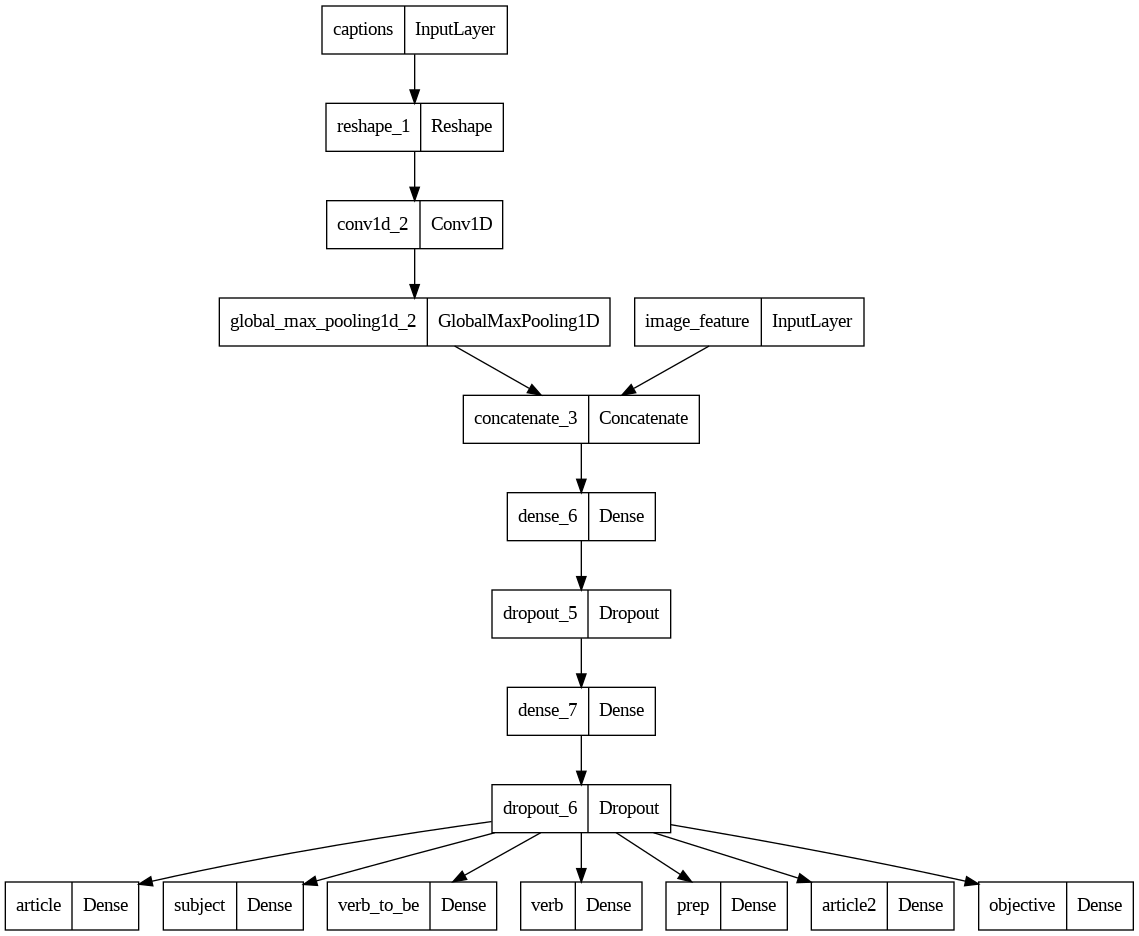

In [ ]:
plot_model(caption_model)

CREATE TRAIN DATA
  - WE HAVE 2 INPUT
  - WE HAVE 7 OUTPUT

# TRAIN ( select 1 option )

TRAIN WITH EARLY STOPPING

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
history = caption_model.fit(
        input_data, output_data,
        callbacks = [callback],
        batch_size=16,
        epochs=1000)

Epoch 1/1000
21/21 [==============================] - 8s 11ms/step - loss: 14.1208 - article_loss: 1.7775 - subject_loss: 2.2088 - verb_to_be_loss: 1.1181 - verb_loss: 2.2183 - prep_loss: 2.1083 - article2_loss: 1.6629 - objective_loss: 3.0269 - article_accuracy: 0.4776 - subject_accuracy: 0.1522 - verb_to_be_accuracy: 0.4896 - verb_accuracy: 0.1493 - prep_accuracy: 0.2269 - article2_accuracy: 0.3433 - objective_accuracy: 0.0657
Epoch 2/1000
21/21 [==============================] - 0s 16ms/step - loss: 12.2169 - article_loss: 1.5077 - subject_loss: 1.9441 - verb_to_be_loss: 1.0933 - verb_loss: 1.8506 - prep_loss: 1.6986 - article2_loss: 1.3611 - objective_loss: 2.7615 - article_accuracy: 0.6030 - subject_accuracy: 0.2806 - verb_to_be_accuracy: 0.4985 - verb_accuracy: 0.2627 - prep_accuracy: 0.3731 - article2_accuracy: 0.4179 - objective_accuracy: 0.0955
Epoch 3/1000
21/21 [==============================] - 0s 12ms/step - loss: 11.6062 - article_loss: 1.4073 - subject_loss: 1.8258 - ver

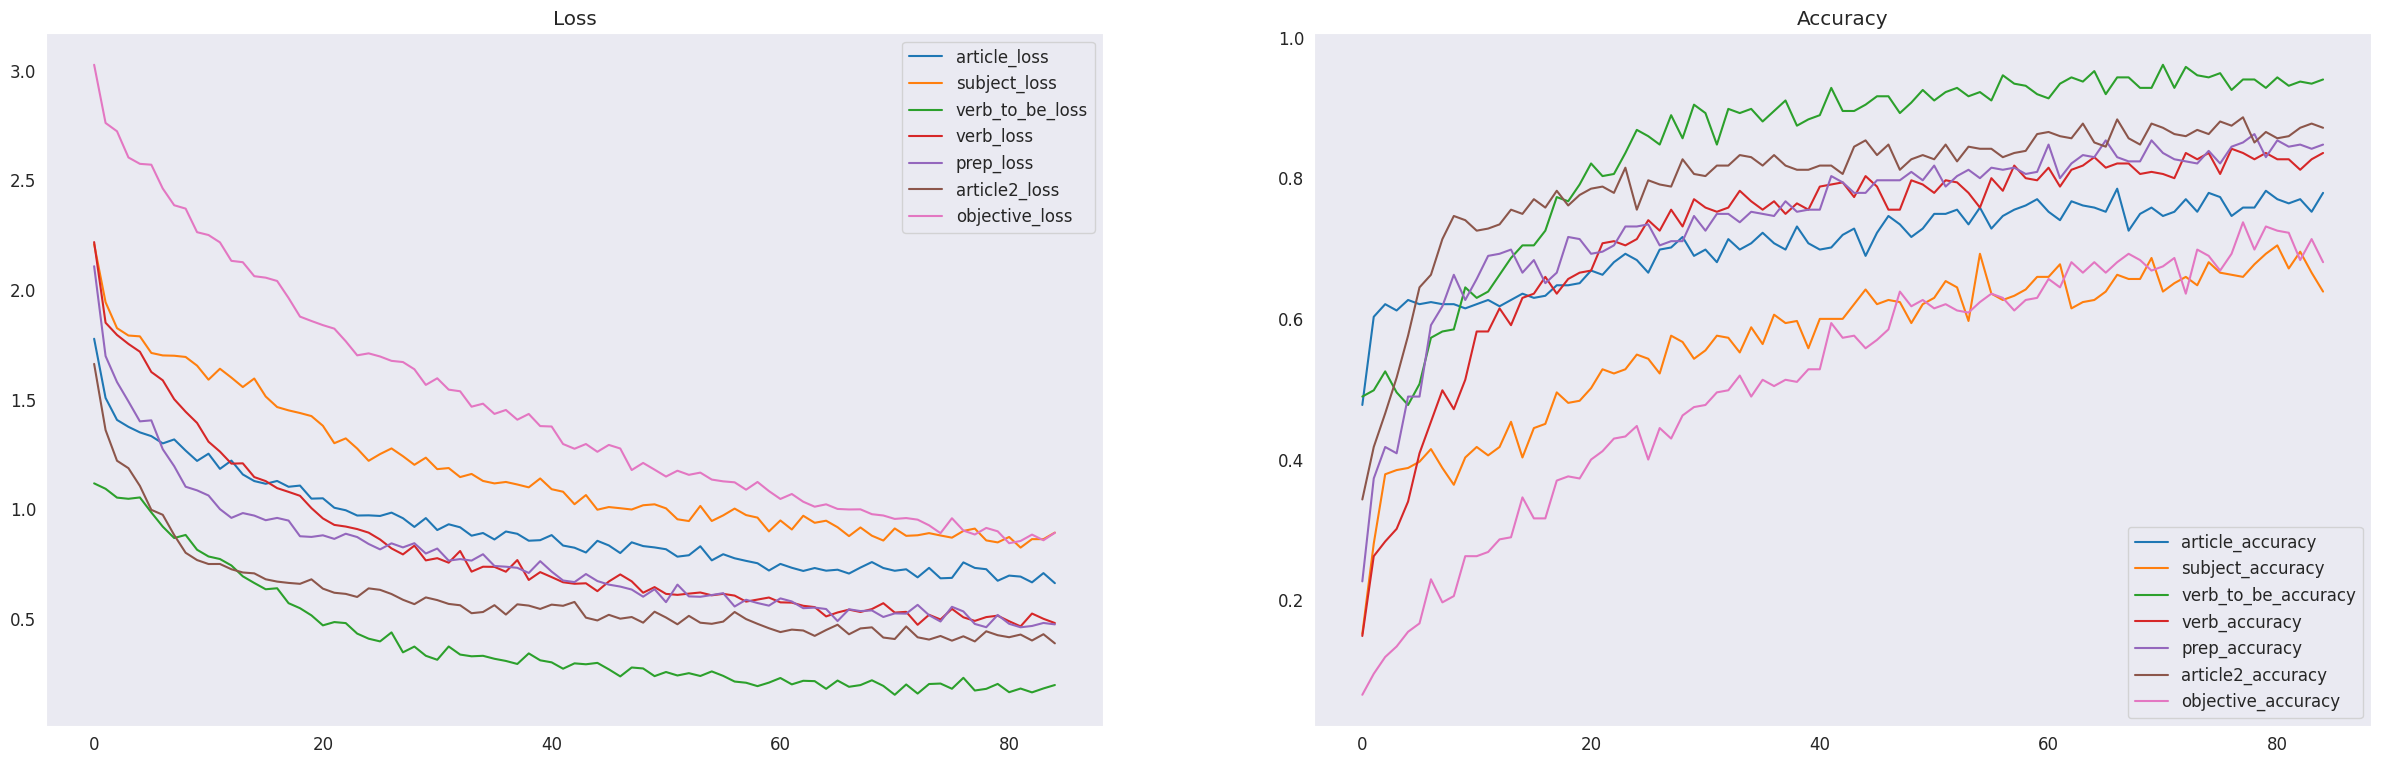

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 9))
ax1.set_title("Loss")
ax1.plot(history.history['article_loss'], label="article_loss")
ax1.plot(history.history['subject_loss'], label="subject_loss")
ax1.plot(history.history['verb_to_be_loss'], label="verb_to_be_loss")
ax1.plot(history.history['verb_loss'], label="verb_loss")
ax1.plot(history.history['prep_loss'], label="prep_loss")
ax1.plot(history.history['article2_loss'], label="article2_loss")
ax1.plot(history.history['objective_loss'], label="objective_loss")
ax1.legend()

ax2.set_title("Accuracy")
ax2.plot(history.history['article_accuracy'], label="article_accuracy")
ax2.plot(history.history['subject_accuracy'], label="subject_accuracy")
ax2.plot(history.history['verb_to_be_accuracy'], label="verb_to_be_accuracy")
ax2.plot(history.history['verb_accuracy'], label="verb_accuracy")
ax2.plot(history.history['prep_accuracy'], label="prep_accuracy")
ax2.plot(history.history['article2_accuracy'], label="article2_accuracy")
ax2.plot(history.history['objective_accuracy'], label="objective_accuracy")
ax2.legend()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 9))
ax1.set_title("Validation Loss")
ax1.plot(history.history['val_article_loss'], label="val_article_loss")
ax1.plot(history.history['val_subject_loss'], label="val_subject_loss")
ax1.plot(history.history['val_verb_to_be_loss'], label="val_verb_to_be_loss")
ax1.plot(history.history['val_verb_loss'], label="val_verb_loss")
ax1.plot(history.history['val_prep_loss'], label="val_prep_loss")
ax1.plot(history.history['val_article2_loss'], label="val_article2_loss")
ax1.plot(history.history['val_objective_loss'], label="val_objective_loss")
ax1.legend()

ax2.set_title("Validation Accuracy")
ax2.plot(history.history['val_article_accuracy'], label="val_article_accuracy")
ax2.plot(history.history['val_subject_accuracy'], label="val_subject_accuracy")
ax2.plot(history.history['val_verb_to_be_accuracy'], label="val_verb_to_be_accuracy")
ax2.plot(history.history['val_verb_accuracy'], label="val_verb_accuracy")
ax2.plot(history.history['val_prep_accuracy'], label="val_prep_accuracy")
ax2.plot(history.history['val_article2_accuracy'], label="val_article2_accuracy")
ax2.plot(history.history['val_objective_accuracy'], label="val_objective_accuracy")
ax2.legend()

# TEST OUR MODEL

In [ ]:
img_size = 224

image = plt.imread("/content/S__23502853_0.jpg")
img = load_img(os.path.join("/content/", "S__23502853_0.jpg"),target_size=(img_size,img_size))
img = img_to_array(img)
img = img/255.
img = np.expand_dims(img,axis=0)
feature = fe.predict(img, verbose=0)
plt.imshow(image)

In [ ]:
import numpy as np

n = 258
img = load_img(os.path.join("/content/drive/MyDrive/MachineLearning/project/image_test_architecture/", images[n]))
plt.imshow(img)

image_features_data = X[n].reshape(1, -1)
# image_features_data = featureฦ
data = np.reshape(image_features_data[0], (1, 1920))
captions_data = np.zeros((1, 7))

predictions = caption_model.predict([data, captions_data], verbose=0)

article_prediction = predictions[0]
subject_prediction = predictions[1]
verb_to_be_prediction = predictions[2]
verb_prediction = predictions[3]
preposition_prediction = predictions[4]
second_article_prediction = predictions[5]
objective_prediction = predictions[6]

# print("Article Prediction:", np.argmax(article_prediction))
# print("Subject Prediction:", np.argmax(subject_prediction))
# print("Verb_to_be Prediction:", np.argmax(verb_to_be_prediction))
# print("Verb Prediction:", np.argmax(verb_prediction))
# print("Preposition Prediction:", np.argmax(preposition_prediction))
# print("Second Article Prediction:", np.argmax(second_article_prediction))
# print("Objective Prediction:", np.argmax(objective_prediction))

# print("Actual :",captions[n])
print("Predict : ", end="")
print(reverse_first_article[np.argmax(article_prediction)], end=" ")
print(reverse_subject[np.argmax(subject_prediction)], end=" ")
print(reverse_verb_to_be[np.argmax(verb_to_be_prediction)], end=" ")
print(reverse_verb[np.argmax(verb_prediction)], end=" ")
print(reverse_preposition[np.argmax(preposition_prediction)], end=" ")
print(reverse_second_article[np.argmax(second_article_prediction)], end=" ")
print(reverse_objective[np.argmax(objective_prediction)], end=" ")

# Model Evaluation with BLEU

In [ ]:
def space_to_question_mark(word):
  if word == "":
    return "?"
  return word

In [ ]:
predict = []

for i in tqdm(range(int(X.shape[0]))):
  image_features_data = X[i].reshape(1, -1)
  data = np.reshape(image_features_data[0], (1, 1920))
  captions_data = np.zeros((1, 7))

  predictions = caption_model.predict([data, captions_data], verbose=0)

  article_prediction = predictions[0]
  subject_prediction = predictions[1]
  verb_to_be_prediction = predictions[2]
  verb_prediction = predictions[3]
  preposition_prediction = predictions[4]
  second_article_prediction = predictions[5]
  objective_prediction = predictions[6]

  caption_predicted = space_to_question_mark(reverse_first_article[np.argmax(article_prediction)]) + " " + space_to_question_mark(reverse_subject[np.argmax(subject_prediction)]) + " " + space_to_question_mark(reverse_verb_to_be[np.argmax(verb_to_be_prediction)]) + " " + space_to_question_mark(reverse_verb[np.argmax(verb_prediction)]) + " " + space_to_question_mark(reverse_preposition[np.argmax(preposition_prediction)]) + " " + space_to_question_mark(reverse_second_article[np.argmax(second_article_prediction)]) + " " + space_to_question_mark(reverse_objective[np.argmax(objective_prediction)])
  predict.append(caption_predicted)

100%|██████████| 330/330 [00:20<00:00, 16.40it/s]


In [ ]:
captions = df['caption']

In [ ]:
predict_splited = []
actual_splited = []
for i, p in enumerate(predict):
  predict_splited.append(predict[i].split())
  actual_splited.append([captions[i].split()])

In [ ]:
!pip install rouge_score

In [ ]:
from rouge_score import rouge_scorer

score = []
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL', 'rougeLsum'])
scores = {'rouge1': [], 'rouge2': [], 'rougeL': [], 'rougeLsum': []}

rouge1 = 0
rouge2 = 0
rougeL = 0
rougeLsum = 0

for i in range(int(len(captions)/5)):
    for ref, pred in zip(captions.tolist()[(i*5):5*(i+1)], predict[:5]):
      current_scores = scorer.score(ref, pred)

      if float(current_scores['rouge1'].fmeasure) > rouge1:
        rouge1 = float(current_scores['rouge1'].fmeasure)

      if float(current_scores['rouge2'].fmeasure) > rouge2:
        rouge2 = float(current_scores['rouge2'].fmeasure)

      if float(current_scores['rougeL'].fmeasure) > rougeL:
        rougeL = float(current_scores['rougeL'].fmeasure)

      if float(current_scores['rougeLsum'].fmeasure) > rougeLsum:
        rougeLsum = float(current_scores['rougeLsum'].fmeasure)

    scores['rouge1'].append(rouge1)
    scores['rouge2'].append(rouge2)
    scores['rougeL'].append(rougeL)
    scores['rougeLsum'].append(rougeLsum)

    rouge1 = 0
    rouge2 = 0
    rougeL = 0
    rougeLsum = 0

print(f"rouge1 score :    {np.mean(scores['rouge1'])}")
print(f"rouge2 score :    {np.mean(scores['rouge2'])}")
print(f"rougeL score :    {np.mean(scores['rougeL'])}")
print(f"rougeLsum score : {np.mean(scores['rougeLsum'])}")

rouge1 score :    0.5652958152958152
rouge2 score :    0.3973544973544974
rougeL score :    0.5619900301718485
rougeLsum score : 0.5619900301718485
